<a href="https://colab.research.google.com/github/rll/deepul/blob/master/homeworks/hw1/hw1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started

## Overview
This semester, all homeworks will be conducted through Google Colab notebooks. All code for the homework assignment will be written and run in this notebook. Running in Colab will automatically provide a GPU, but you may also run this notebook locally by following [these instructions](https://research.google.com/colaboratory/local-runtimes.html) if you wish to use your own GPU.

You will save images in the notebooks to use and fill out a given LaTeX template which will be submitted to Gradescope, along with your notebook code.

## Using Colab
On the left-hand side, you can click the different icons to see a Table of Contents of the assignment, as well as local files accessible through the notebook.

Make sure to go to **Runtime -> Change runtime type** and select **GPU** as the hardware accelerator. This allows you to use a GPU. Run the cells below to get started on the assignment. Note that a session is open for a maximum of 12 hours, and using too much GPU compute may result in restricted access for a short period of time. Please start the homework early so you have ample time to work.

**If you load this notebook by clicking "Open in Colab" from github, you will need to save it to your own Google Drive to keep your work.**

## General Tips
In each homework problem, you will implement autoregressive models and run it on various datasets. Oftentime you will run it on two datasets (dataset 1 and dataset 2). In these cases, the expected outputs for dataset 1 are already provided to help as a sanity check.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the images outputted in the results/ folder and upload them to the figure folder in the given latex template.

There is a lot of freedom in this homework to design write and design your own models. Hyperparameters are given as a guide to show what worked for us, but feel free to explore and use what you find is best!

Run the cells below to download and load up the starter code.

In [1]:
# !if [ -d deepul ]; then rm -Rf deepul; fi
# !git clone https://github.com/rll/deepul.git 
# !unzip -qq deepul/homeworks/hw1/data/hw1_data.zip -d deepul/homeworks/hw1/data/
# !pip install ./deepul

In [2]:
import numpy as np
import copy
# import jax.numpy as np

from deepul.hw1_helper import (
    # Q1
    visualize_q1_data,
    q1_sample_data_1,
    q1_sample_data_2,
    q1_save_results,
    # Q2
    q2a_save_results,
    q2b_save_results,
    visualize_q2a_data,
    visualize_q2b_data,
    # Q3
    
    q3ab_save_results,
    q3c_save_results,
    # Q4
    q4a_save_results,
    q4b_save_results,
    # Q5
    visualize_q5_data,
    q5a_save_results,
    # Q6
    visualize_q6_data,
    q6a_save_results,
)

# Question 1: 1D Data

In this question, we will train simple generative models on discrete 1D data.

Execute the cell below to visualize our datasets

Dataset 1


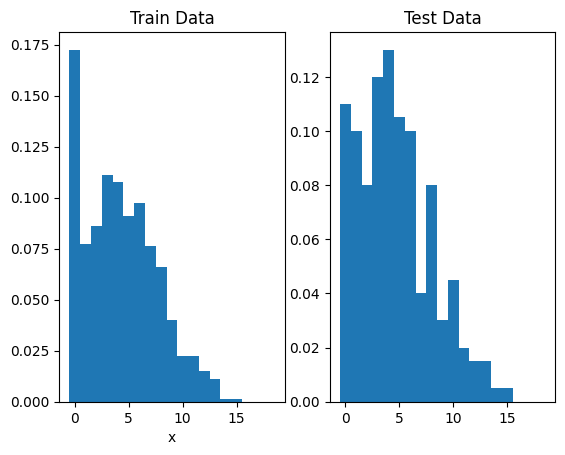

Dataset 2


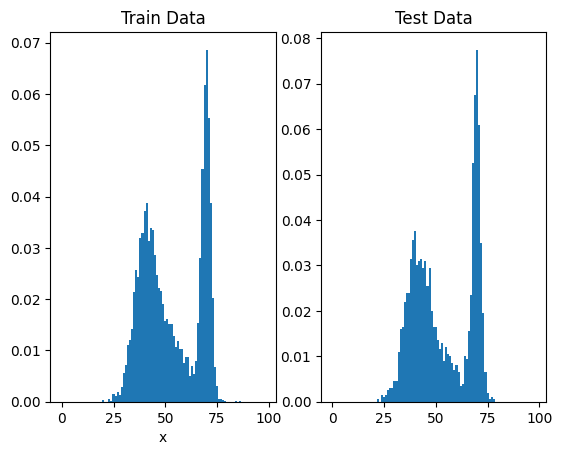

In [3]:
visualize_q1_data(dset_type=1)
visualize_q1_data(dset_type=2)

## Part (a) Fitting a Histogram

Let $\theta = (\theta_0, \dots, \theta_{d-1}) \in \mathbb{R}^{d}$ and define the model $p_\theta(x) = \frac{e^{\theta_x}}{\sum_{x'}e^{\theta_{x'}}}$

Fit $p_\theta$ with maximum likelihood via stochastic gradient descent on the training set, using $\theta$ initialized to zero. Use your favorite version of stochastic gradient descent, and optimize your hyperparameters on a validation set of your choice.

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. Plot the model probabilities in a bar graph with $\{0,\dots,d-1\}$ on the x-axis and a real number in $[0,1]$ on the y-axis.




Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [4]:

def softmax_probs(theta):
    """Computes all softmax probabilities for given theta."""
    theta_shifted = theta - np.max(theta)  # Stability trick
    exp_theta = np.exp(theta_shifted)
    return exp_theta / np.sum(exp_theta)
def q1_a(train_data, test_data, d, dset_id):
    """
    Optimized version of q1_a for better performance
    """
    train_losses = []
    test_losses = []
    theta = np.zeros(d, dtype=float)
    y = np.bincount(train_data, minlength=d) / len(train_data)
    
    print("train_data shape: ", train_data.shape)
    print("d: ", d)
    print("dset_id", dset_id)

    # Hyperparameters
    epochs = 200000
    learning_rate = 0.1
    
    # Calculate test loss only periodically
    eval_interval = 10
    
    # Pre-allocate arrays
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    
    for epoch in range(epochs):
        probs = softmax_probs(theta)
        nll = -np.mean(np.log(probs[train_data]))
        d_nll = probs - y
        
        theta -= learning_rate * d_nll
        train_losses[epoch] = nll
        
        # Calculate test loss only periodically
        if epoch % eval_interval == 0:
            t_nll = -np.mean(np.log(probs[test_data]))
            test_losses[epoch] = t_nll
        elif epoch > 0:  # Copy the previous value for non-evaluated epochs
            test_losses[epoch] = test_losses[epoch-1]
    
    distribution = softmax_probs(theta)
    return train_losses, test_losses, distribution

### Results

Once you've implemented `q1_a`, execute the cells below to visualize and save your results



train_data shape:  (800,)
d:  20
dset_id 1


Final Test Loss: 2.5434


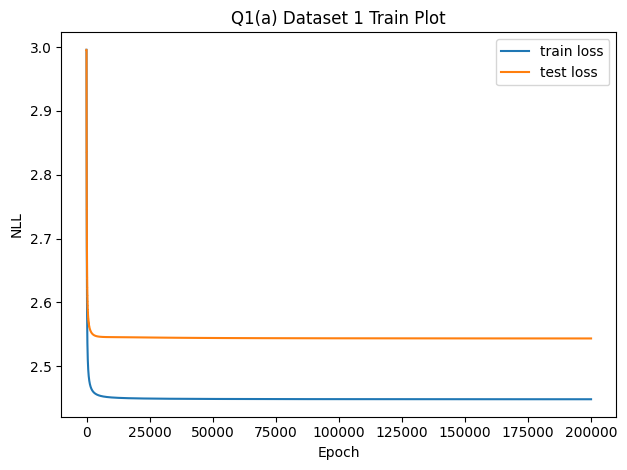

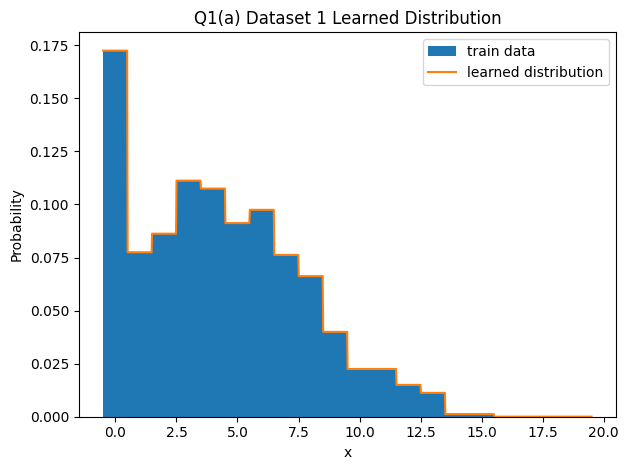

In [5]:
q1_save_results(1, 'a', q1_a)

train_data shape:  (8000,)
d:  100
dset_id 2
Final Test Loss: 3.6623


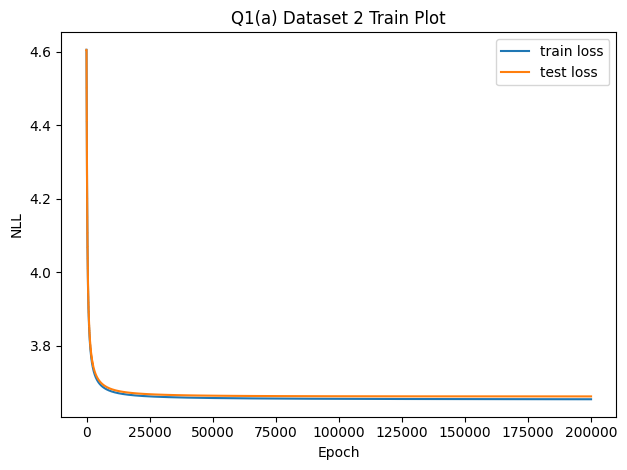

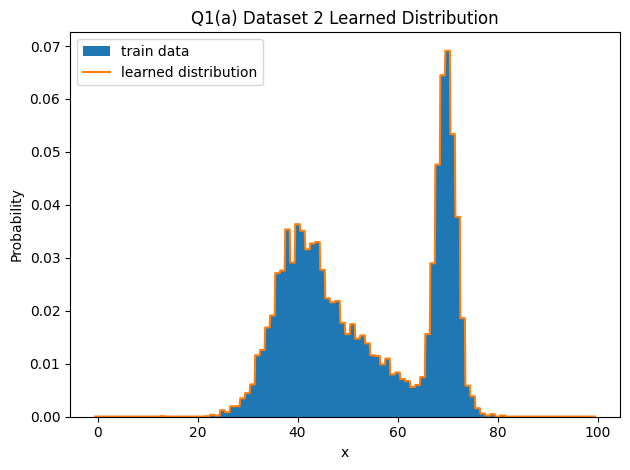

In [6]:
q1_save_results(2, 'a', q1_a)

## Part (b) Fitting Discretized Mixture of Logistics

Let us model $p_\theta(x)$ as a **discretized** mixture of 4 logistics such that $p_\theta(x) = \sum_{i=1}^4 \pi_i[\sigma((x+0.5 - \mu_i)/s_i) - \sigma((x-0.5-\mu_i)/s_i)]$

For the edge case of when $x = 0$, we replace $x-0.5$ by $-\infty$, and for $x = 99$, we replace $x+0.5$ by $\infty$.

You may find the [PixelCNN++](https://arxiv.org/abs/1701.05517) helpful for more information on discretized mixture of logistics.

**Provide the same set of corresponding deliverables as part (a)**

Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

class MixtureOfLogistics(nn.Module):
    """Mixture of Logistics distribution model for discrete data."""
    
    def __init__(self, d, n_mix=4):
        """
        Initialize the Mixture of Logistics model.
        
        Args:
            d: Number of possible discrete values (0 to d-1)
            n_mix: Number of mixture components
        """
        super().__init__()
        self.d = d
        self.n_mix = n_mix
        
        # TODO: Initialize model parameters
        # 1. Mixture weights (logit_probs)
        # 2. Component means (means)
        # 3. Component scales (log_scales)
        self.logit_probs = nn.Parameter(torch.zeros(n_mix)) # shape (n_mix,)
        init_means = torch.linspace(0,d-1,n_mix) + torch.randn(n_mix)*0.1  #shape (n_mix,)
        self.means = nn.Parameter(torch.clamp(init_means,0,d-1))
        self.log_scales = nn.Parameter(torch.ones(n_mix)*0.5) # shape (n_mix,1)
        
    
    def forward(self, x):
        """
        Compute the log probability of each value in x.
        
        Args:
            x: tensor of shape (batch_size,) containing integers in {0, ..., d-1}
            
        Returns:
            tensor of shape (batch_size,) containing log probabilities
        """
        # TODO: Implement forward pass
        # 1. Get mixture weights using softmax on logit_probs
        # 2. Ensure scales are positive (e.g., using softplus)
        # 3. Calculate CDF at x+0.5 and x-0.5 for each component
        # 4. Handle edge cases (x=0 and x=d-1)
        # 5. Compute probabilities from CDF differences
        # 6. Weight by mixture weights and sum
        # 7. Return log probabilities
        probs = torch.softmax(self.logit_probs, dim=0)  # n_mix
        probs = probs.unsqueeze(0)  # 1, n_mix

        scales = nn.functional.softplus(self.log_scales)  # n_mix 
        scales = scales.unsqueeze(0)  # 1, n_mix

        x = x.unsqueeze(1)  # batch_size,1
        x_float = x.float()
        first_term = torch.sigmoid((x_float + 0.5 - self.means) / scales)
        second_term = torch.sigmoid((x_float - 0.5 - self.means) / scales)

        # Handle edge cases
        is_d_minus_one = (x == self.d - 1)
        is_zero = (x == 0)
        first_term = torch.where(is_d_minus_one, torch.ones_like(first_term), first_term)
        second_term = torch.where(is_zero, torch.zeros_like(second_term), second_term)

        # Calculate component probabilities
        component_probs = first_term - second_term  # batch_size, n_mix
        probabilities = probs * component_probs  # batch_size, n_mix
        probabilities = probabilities.sum(dim=1)  # batch_size

        # Return log probabilities
        return torch.log(probabilities + 1e-10)
    
    def get_distribution(self):
        """
        Returns the probability distribution over all possible values.
        
        Returns:
            numpy array of shape (d,) containing probabilities
        """
        device = next(self.parameters()).device
        x = torch.arange(self.d, device=device)
        with torch.no_grad():
            log_probs = self.forward(x)
            probs = torch.exp(log_probs)
            return (probs / torch.sum(probs)).cpu().numpy()


def q1_b(train_data, test_data, d, dset_id):
    """
    Train a mixture of logistics model on discrete data.
    """
    # Set random seed and device
    torch.manual_seed(42)
    np.random.seed(42)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Convert data to tensors
    train_tensor = torch.tensor(train_data, dtype=torch.long, device=device)
    test_tensor = torch.tensor(test_data, dtype=torch.long, device=device)
    
    # Create dataset and dataloader
    train_dataset = TensorDataset(train_tensor)
    test_dataset = TensorDataset(test_tensor)
    # Set hyperparameters based on dataset ID
    hyperparams = {
        1: {"batch_size": 800, "lr": 0.005, "num_epochs": 1}, 
        2: {"batch_size": 800, "lr": 0.001, "num_epochs": 1}
    }[dset_id]
    
    train_loader = DataLoader(
        train_dataset, 
        batch_size=hyperparams["batch_size"], 
        shuffle=True
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=hyperparams["batch_size"],
        shuffle=False
    )
    train_losses = np.zeros(hyperparams["num_epochs"])
    test_losses = np.zeros(hyperparams["num_epochs"])
    # Initialize model and optimizer
    model = MixtureOfLogistics(d, n_mix=4).to(device)
    optimizer = optim.Adam(model.parameters(), lr=hyperparams["lr"])
    
    # TODO: Implement training loop
    # 1. Track training and test losses
    # 2. For each epoch:
    #    a. Train the model on batches
    #    b. Compute and record loss
    #    c. Evaluate on test set
    for epoch in range(hyperparams["num_epochs"]):
        model.train()
        train_loss = 0.0
        for batch in train_loader:
            optimizer.zero_grad()
            x = batch[0].to(device)
            log_probs = model(x)
            nll = -log_probs.mean()
            nll.backward()
            
            optimizer.step()
            train_loss += nll.item()
        train_losses[epoch] = train_loss / len(train_loader)
        
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for batch in test_loader:
                x = batch[0].to(device)
                log_probs = model(x)
                nll = -log_probs.mean()
                test_loss += nll.item()
        test_losses[epoch] = test_loss / len(test_loader)
    # Get final model probabilities
    model.eval()
    model_probs = model.get_distribution()
    print("len(model_probs)", len(model_probs))
    # Return placeholder values for now
    return train_losses, test_losses, model_probs

### Results

Once you've implemented `q1_b`, execute the cells below to visualize and save your results



/home/nghiaph/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


len(model_probs) 20
Final Test Loss: 3.1956


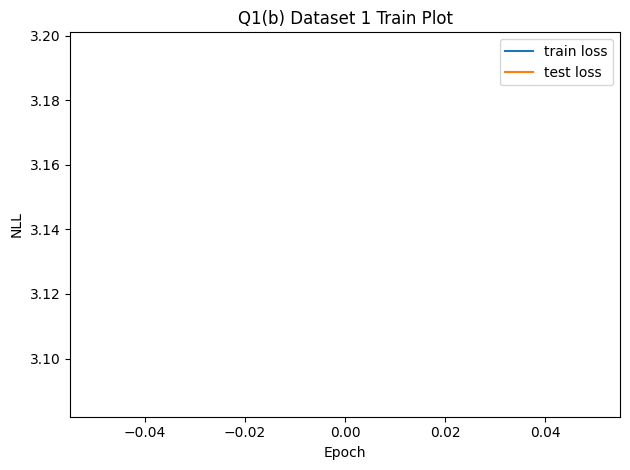

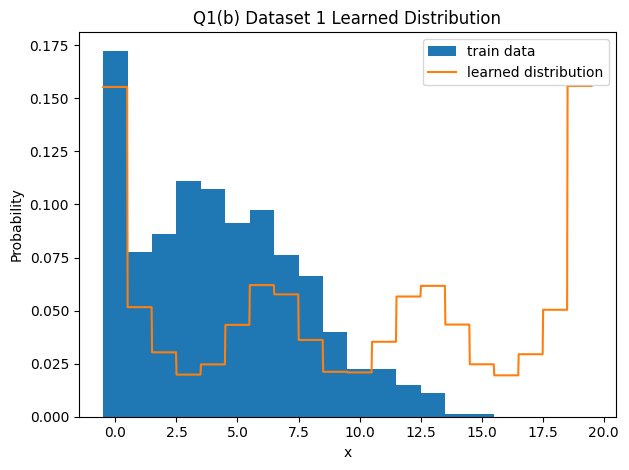

In [8]:
q1_save_results(1, 'b', q1_b)

len(model_probs) 100
Final Test Loss: 8.4007


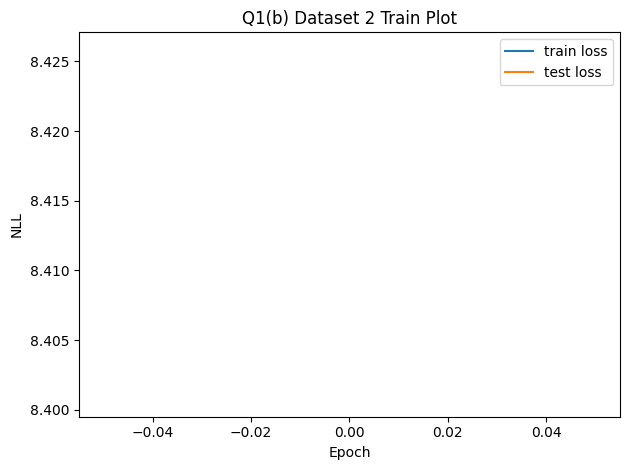

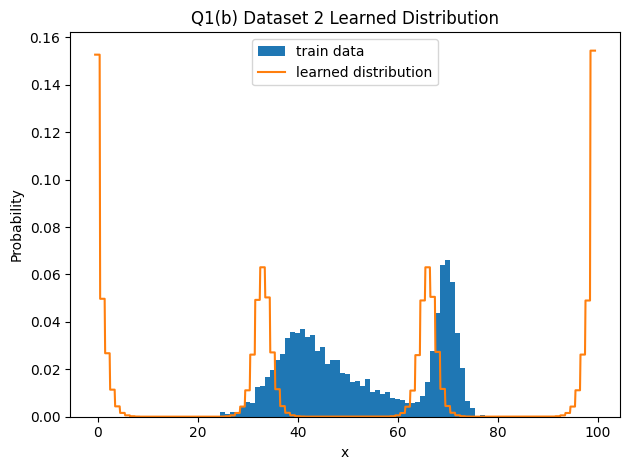

In [9]:
q1_save_results(2, 'b', q1_b)

# Question 2 PixelCNNs

Now, you will train more powerful PixelCNN models on the shapes dataset and MNIST. In addition, we will extend to modeling colored datasets.

Run the cell below to visualize the two datasets binary datasets

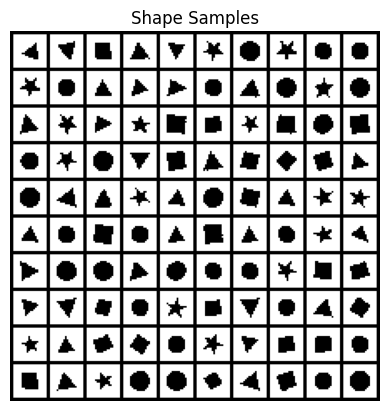

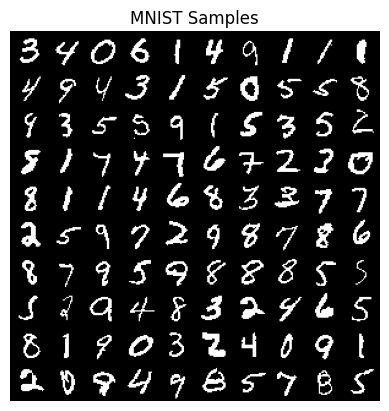

In [10]:
visualize_q2a_data(1)
visualize_q2a_data(2)

## Part (a) PixelCNN on Shapes and MNIST
In this part, implement a simple PixelCNN architecture to model binary MNIST and shapes images (same as Q2(b), but with a PixelCNN).

We recommend the following network design:
* A $7 \times 7$ masked type A convolution
* $5$ $7 \times 7$ masked type B convolutions
* $2$ $1 \times 1$ masked type B convolutions
* Appropriate ReLU nonlinearities in-between
* 64 convolutional filters

And the following hyperparameters:
* Batch size 128
* Learning rate $10^{-3}$
* 10 epochs
* Adam Optimizer (this applies to all PixelCNN models trained in future parts)

Your model should output logits, after which you could apply a sigmoid over 1 logit, or a softmax over two logits (either is fine). It may also help to scale your input to $[-1, 1]$ before running it through the network. 

Training on the shapes dataset should be quick, and MNIST should take around 10 minutes

Checkout the Paper for more details: https://arxiv.org/abs/1601.06759

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model



Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from tqdm import tqdm

class MaskedConv2d(nn.Conv2d):
    """
    Implementation of a masked convolution layer for PixelCNN.
    Masks can be of type 'A' or 'B'.
    """
    def __init__(self, in_channels, out_channels, kernel_size, mask_type='A', padding='same', **kwargs):
        super(MaskedConv2d, self).__init__(in_channels, out_channels, kernel_size, padding=padding, **kwargs)
        self.register_buffer('mask', torch.ones_like(self.weight))
        self.mask_type = mask_type
        
        # Create mask
        h, w = kernel_size, kernel_size
        if isinstance(kernel_size, int):
            h, w = kernel_size, kernel_size
            
        center_h, center_w = h // 2, w // 2
        
        # For all spatial locations
        for i in range(h):
            for j in range(w):
                # Mask out future pixels (below and to the right)
                if (i > center_h) or (i == center_h and j > center_w):
                    self.mask[:, :, i, j] = 0
                    
                # For mask type A, also mask out the center pixel
                if mask_type == 'A' and i == center_h and j == center_w:
                    self.mask[:, :, i, j] = 0
    
    def forward(self, x):
        # Apply the mask to weights
        self.weight.data *= self.mask
        return super(MaskedConv2d, self).forward(x)

class PixelCNN(nn.Module):
    """
    PixelCNN model for binary image generation.
    As recommended in the assignment:
    - One 7x7 masked type A convolution
    - Five 7x7 masked type B convolutions
    - Two 1x1 masked type B convolutions
    - ReLU nonlinearities in-between
    - 64 convolutional filters
    """
    def __init__(self, in_channels=1, hidden_dim=64):
        super(PixelCNN, self).__init__()
        
        # Initial masked convolutional layer of type A
        self.conv_a = MaskedConv2d(in_channels, hidden_dim, kernel_size=7, mask_type='A', padding='same')
        
        # Stack of masked convolutional layers of type B
        self.conv_b_stack = nn.ModuleList([
            MaskedConv2d(hidden_dim, hidden_dim, kernel_size=7, mask_type='B', padding='same')
            for _ in range(5)
        ])
        
        # Final 1x1 convolutions
        self.conv_1x1_stack = nn.ModuleList([
            MaskedConv2d(hidden_dim, hidden_dim, kernel_size=1, mask_type='B', padding='same')
            for _ in range(2)
        ])
        
        # Output layer: 1 channel for binary output (will apply sigmoid later)
        self.output_conv = MaskedConv2d(hidden_dim, 1, kernel_size=1, mask_type='B', padding='same')
        
    def forward(self, x):
        # Apply first mask A convolution
        x = F.relu(self.conv_a(x))
        
        # Apply mask B convolutions with ReLU
        for conv_b in self.conv_b_stack:
            x = F.relu(conv_b(x))
            
        # Apply 1x1 convolutions with ReLU
        for conv_1x1 in self.conv_1x1_stack:
            x = F.relu(conv_1x1(x))
            
        # Final output layer (returns logits)
        x = self.output_conv(x)
        
        return x

def sample_from_model(model, image_shape, device, num_samples=100):
    """
    Sample images from the trained model using ancestral sampling.
    """
    model.eval()
    samples = torch.zeros((num_samples, 1, image_shape[0], image_shape[1]), device=device)
    
    with torch.no_grad():
        # Generate each pixel sequentially
        for i in range(image_shape[0]):
            for j in range(image_shape[1]):
                # Get the model's prediction
                logits = model(samples)[:, :, i, j]
                # Convert logits to probabilities
                probs = torch.sigmoid(logits)
                # Sample from Bernoulli distribution
                samples[:, :, i, j] = torch.bernoulli(probs)
    
    return samples.cpu().numpy().transpose(0, 2, 3, 1)

def binary_cross_entropy_loss(logits, targets):
    """
    Compute binary cross entropy loss from logits.
    """
    return F.binary_cross_entropy_with_logits(logits, targets)

def negative_log_likelihood(logits, targets):
    """
    Compute negative log likelihood in nats per dimension.
    """
    batch_size = targets.size(0)
    n_dims = targets.size(1) * targets.size(2) * targets.size(3)
    
    # Compute binary cross entropy (already in log scale)
    bce = binary_cross_entropy_loss(logits, targets)
    
    # Convert to nats (from bits) and normalize by dimensions
    # No need for conversion as PyTorch already uses natural log
    nll = bce * n_dims
    
    return nll

def q2_a(train_data, test_data, image_shape, dset_id):
    """
    train_data: A (n_train, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
    test_data: A (n_test, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
    image_shape: (H, W), height and width of the image
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
             used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (100, H, W, 1) of samples with values in {0, 1}
    """
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Hyperparameters
    batch_size = 128
    learning_rate = 1e-3
    num_epochs = 10
    
    # Convert data to PyTorch tensors and scale to [-1, 1]
    train_data = torch.from_numpy(train_data).float().permute(0, 3, 1, 2).to(device)
    test_data = torch.from_numpy(test_data).float().permute(0, 3, 1, 2).to(device)
    
    # Create data loaders
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)
    
    # Initialize model, optimizer
    model = PixelCNN(in_channels=1, hidden_dim=64).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Lists to store metrics
    train_losses = []
    test_losses = []
    
    # Initial test loss
    model.eval()
    total_test_loss = 0
    with torch.no_grad():
        for data in test_loader:
            outputs = model(data)
            loss = negative_log_likelihood(outputs, data)
            total_test_loss += loss.item()
    initial_test_loss = total_test_loss / len(test_loader)
    test_losses.append(initial_test_loss)
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
        
        for batch_idx, data in enumerate(progress_bar):
            optimizer.zero_grad()
            outputs = model(data)
            loss = binary_cross_entropy_loss(outputs, data)
            loss.backward()
            optimizer.step()
            
            # Track the average NLL per dimension
            nll = negative_log_likelihood(outputs, data)
            train_losses.append(nll.item())
            
            progress_bar.set_postfix({'Loss': nll.item()})
        
        # Evaluate on test set after each epoch
        model.eval()
        total_test_loss = 0
        with torch.no_grad():
            for data in test_loader:
                outputs = model(data)
                loss = negative_log_likelihood(outputs, data)
                total_test_loss += loss.item()
        epoch_test_loss = total_test_loss / len(test_loader)
        test_losses.append(epoch_test_loss)
        
        print(f'Epoch {epoch+1}: Test Loss: {epoch_test_loss:.6f}')
    
    # Generate samples
    samples = sample_from_model(model, image_shape, device, num_samples=100)
    samples = (samples > 0.5).astype(np.uint8)  # Convert probabilities to binary
    
    return np.array(train_losses), np.array(test_losses), samples

### Results

Once you've implemented `q2_a`, execute the cells below to visualize and save your results



/home/nghiaph/miniconda3/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
Epoch 1/10: 100%|██████████| 82/82 [00:01<00:00, 69.53it/s, Loss=60.5]


Epoch 1: Test Loss: 62.297580


Epoch 2/10: 100%|██████████| 82/82 [00:01<00:00, 81.22it/s, Loss=60.3]


Epoch 2: Test Loss: 57.917084


Epoch 3/10: 100%|██████████| 82/82 [00:01<00:00, 80.17it/s, Loss=51]  


Epoch 3: Test Loss: 49.822861


Epoch 4/10: 100%|██████████| 82/82 [00:01<00:00, 80.10it/s, Loss=43.2]


Epoch 4: Test Loss: 44.468886


Epoch 5/10: 100%|██████████| 82/82 [00:01<00:00, 80.93it/s, Loss=39.4]


Epoch 5: Test Loss: 39.174904


Epoch 6/10: 100%|██████████| 82/82 [00:01<00:00, 80.96it/s, Loss=36.6]


Epoch 6: Test Loss: 34.382921


Epoch 7/10: 100%|██████████| 82/82 [00:01<00:00, 80.87it/s, Loss=29.8]


Epoch 7: Test Loss: 30.447612


Epoch 8/10: 100%|██████████| 82/82 [00:01<00:00, 80.63it/s, Loss=28.9]


Epoch 8: Test Loss: 27.884689


Epoch 9/10: 100%|██████████| 82/82 [00:01<00:00, 80.89it/s, Loss=23.2]


Epoch 9: Test Loss: 24.504693


Epoch 10/10: 100%|██████████| 82/82 [00:01<00:00, 80.54it/s, Loss=21.9]


Epoch 10: Test Loss: 22.744405
Final Test Loss: 22.7444


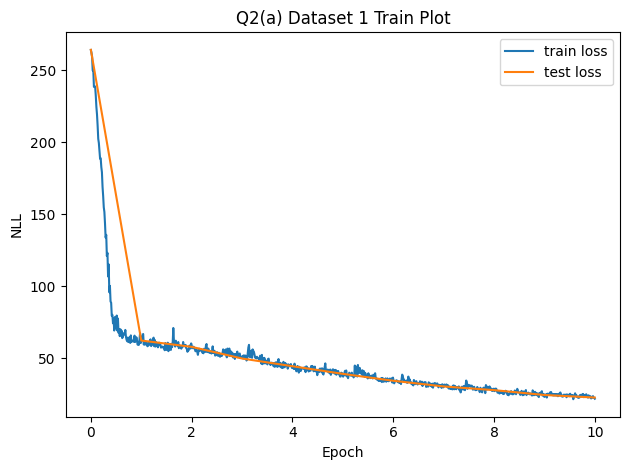

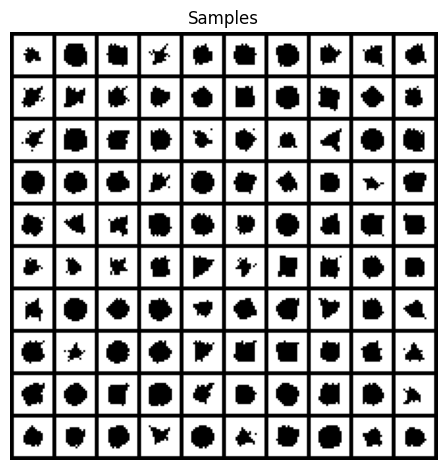

In [12]:
q2a_save_results(1, q2_a)

Epoch 1/10: 100%|██████████| 469/469 [00:11<00:00, 39.12it/s, Loss=68.6]


Epoch 1: Test Loss: 69.913991


Epoch 2/10: 100%|██████████| 469/469 [00:12<00:00, 38.98it/s, Loss=66.9]


Epoch 2: Test Loss: 66.808169


Epoch 3/10: 100%|██████████| 469/469 [00:12<00:00, 38.91it/s, Loss=63.5]


Epoch 3: Test Loss: 65.442550


Epoch 4/10: 100%|██████████| 469/469 [00:12<00:00, 38.95it/s, Loss=63.2]


Epoch 4: Test Loss: 63.289353


Epoch 5/10: 100%|██████████| 469/469 [00:11<00:00, 39.17it/s, Loss=63.2]


Epoch 5: Test Loss: 63.079290


Epoch 6/10: 100%|██████████| 469/469 [00:12<00:00, 38.77it/s, Loss=63.5]


Epoch 6: Test Loss: 62.473125


Epoch 7/10: 100%|██████████| 469/469 [00:12<00:00, 38.34it/s, Loss=65]  


Epoch 7: Test Loss: 61.882597


Epoch 8/10: 100%|██████████| 469/469 [00:12<00:00, 38.95it/s, Loss=61.2]


Epoch 8: Test Loss: 61.819381


Epoch 9/10: 100%|██████████| 469/469 [00:11<00:00, 39.28it/s, Loss=60.8]


Epoch 9: Test Loss: 61.755932


Epoch 10/10: 100%|██████████| 469/469 [00:11<00:00, 39.11it/s, Loss=62.5]


Epoch 10: Test Loss: 61.846889
Final Test Loss: 61.8469


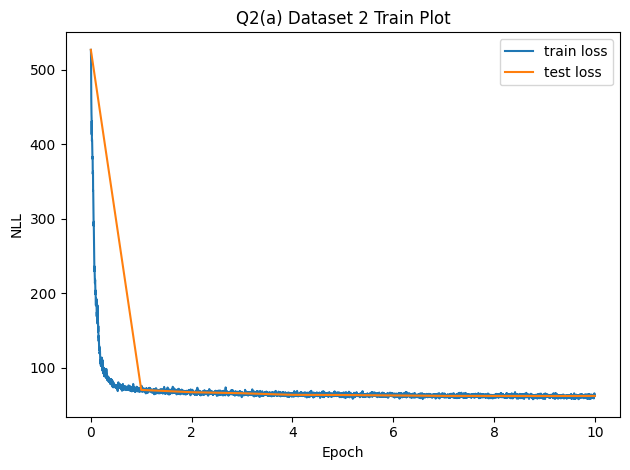

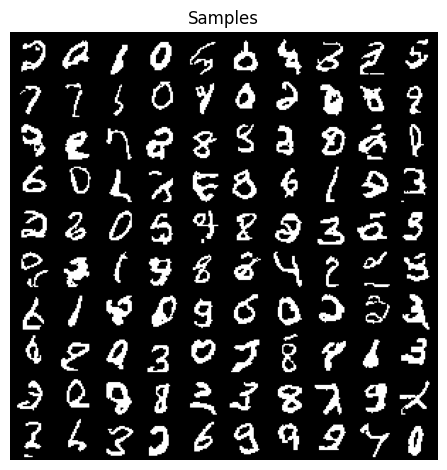

In [13]:
q2a_save_results(2, q2_a)

## Part (b) PixelCNN on Colored Shapes and MNIST: Independent Color Channels

For the next part, we'll work with color images (shapes and MNIST). Run the cell below to visualize the dataset.

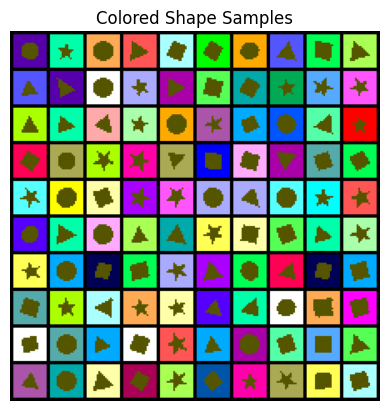

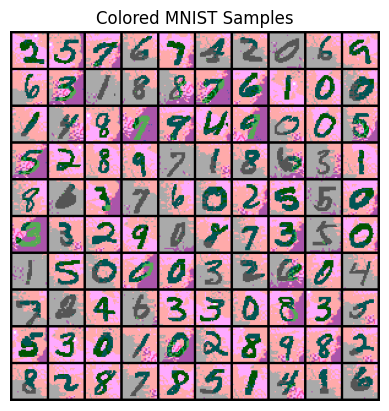

In [14]:
visualize_q2b_data(1)
visualize_q2b_data(2)

Now, implement a PixelCNN to support RGB color channels (or augment your existing implementation). **First, implement a PixelCNN that assumes color channels as independent.** More formally, we model the following parameterized distribution:

$$p_\theta(x) = \prod_{i=1}^{HW}\prod_{c=1}^C p_\theta(x_i^c | x_{<i})$$

Here are some tips that you may find useful for designing and training these models:
* You will need a 4-way softmax for every prediction, as opposed to a 256-way softmax in the PixelCNN paper, since the dataset is quantized to two bits per color channel
* You can set the number of filters for each convolutions to 120. You can use the ReLU nonlinearity throughout.
* Use a stack of 8 residual block architecture from [Figure 5](https://arxiv.org/abs/1601.06759) but with 7 x 7 masked convolutions in the middle instead of 3 x 3 masked convolutions
* Consider using [layer normalization](https://arxiv.org/abs/1607.06450) to improve performance. However, be careful to maintain the autoregressive property.
* With a learning rate of $10^{-3}$ and a batch size of 128, it should take a few minutes to run on the shapes dataset, and about 50-60 minutes on MNIST.

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model



Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [15]:
import torch
import torch.optim as optim
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

quiet = False

def train(model, train_loader, optimizer, epoch, grad_clip=None):
  model.train()
  
  train_losses = []
  for x in train_loader:
    x = x.cuda().contiguous()
    loss = model.loss(x)
    optimizer.zero_grad()
    loss.backward()
    if grad_clip:
      torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
    optimizer.step()
    train_losses.append(loss.item())
  return train_losses

def eval_loss(model, data_loader):
  model.eval()
  total_loss = 0
  with torch.no_grad():
    for x in data_loader:
      x = x.cuda().contiguous()
      loss = model.loss(x)
      total_loss += loss * x.shape[0]
    avg_loss = total_loss / len(data_loader.dataset)

  return avg_loss.item()


def train_epochs(model, train_loader, test_loader, train_args):
  epochs, lr = train_args['epochs'], train_args['lr']
  grad_clip = train_args.get('grad_clip', None)
  optimizer = optim.Adam(model.parameters(), lr=lr)

  train_losses = []
  test_losses = [eval_loss(model, test_loader)]
  for epoch in range(epochs):
    model.train()
    train_losses.extend(train(model, train_loader, optimizer, epoch, grad_clip))
    test_loss = eval_loss(model, test_loader)
    test_losses.append(test_loss)
    if not quiet:
      print(f'Epoch {epoch}, Test loss {test_loss:.4f}')

  return train_losses, test_losses

class Histogram(nn.Module):
  def __init__(self, d):
    super().__init__()
    self.d = d
    self.logits = nn.Parameter(torch.zeros(d), requires_grad=True)

  def loss(self, x):
    logits = self.logits.unsqueeze(0).repeat(x.shape[0], 1) # batch_size x d
    return F.cross_entropy(logits, x.long())

  def get_distribution(self):
    distribution = F.softmax(self.logits, dim=0)
    return distribution.detach().cpu().numpy()

In [16]:
class MaskedConv2d(nn.Conv2d):
    """
    Implementation of Masked Convolution for PixelCNN
    """
    def __init__(self, mask_type, *args, **kwargs):
        assert mask_type == 'A' or mask_type == 'B'
        super().__init__(*args, **kwargs)
        self.register_buffer('mask', torch.zeros_like(self.weight))
        self.create_mask(mask_type)

    def forward(self, input):
        # Apply convolution with mask
        out = F.conv2d(input, self.weight * self.mask, self.bias, self.stride,
                      self.padding, self.dilation, self.groups)
        return out

    def create_mask(self, mask_type):
        # Get kernel size (assuming square kernel)
        k = self.kernel_size[0]
        
        # Set mask to 1 for all positions above the center
        self.mask[:, :, :k // 2] = 1
        
        # Set mask to 1 for positions to the left of center in the center row
        self.mask[:, :, k // 2, :k // 2] = 1
        
        # For type B masks, also set the center pixel to 1
        if mask_type == 'B':
            self.mask[:, :, k // 2, k // 2] = 1
    
class LayerNorm(nn.LayerNorm):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def forward(self, x):
        x = x.permute(0, 2, 3, 1).contiguous()
        
        # Apply normalization (normalized_shape now matches)
        x = super().forward(x)
        
        # Permute back to [batch, channels, height, width]
        return x.permute(0, 3, 1, 2).contiguous()
  
class ResidualBlock(nn.Module):
    def __init__(self, n_filters, image_shape=None):
        super(ResidualBlock, self).__init__()
        # layer nornalization 
        H, W, _ = image_shape if image_shape is not None else (20, 20, 3) 
        self.layer_norm1 = LayerNorm(n_filters , H, W)
        self.layer_norm2 = LayerNorm(n_filters , H, W)
        self.layer_norm3 = LayerNorm(n_filters , H, W)

        # Main path
        self.conv1 = nn.Conv2d(n_filters, n_filters, kernel_size=1)
        self.conv2 = MaskedConv2d('B', n_filters, n_filters, kernel_size=7, padding=3)
        self.conv3 = nn.Conv2d(n_filters, n_filters, kernel_size=1)

        self.relu = nn.ReLU()
        
    def forward(self, x):
        # Store input for the skip connection
        
        identity = x
        
        # Main path
        out = self.layer_norm1(x)
        out = self.relu(out)
        out = self.conv1(out)
        
        out = self.layer_norm2(out)
        out = self.relu(out)
        out = self.conv2(out)
        
        out = self.layer_norm3(out)
        out = self.relu(out)   
        out = self.conv3(out)

        # Skip connection
        out += identity        
        return out

In [17]:
def compute_loss(logits, targets):
    """
    Compute cross-entropy loss for the PixelCNN model.
    
    Args:
        logits: Tensor of shape [batch_size, C, 4, H, W] - model predictions
        targets: Tensor of shape [batch_size, C, H, W] - ground truth values
        
    Returns:
        Average cross-entropy loss
    """
    logits_reshaped = logits.permute(0, 1, 3, 4, 2).reshape(-1, 4) # [batch_size, C, H, W 4]
    targets_reshaped = targets.reshape(-1).long()
    return F.cross_entropy(logits_reshaped, targets_reshaped)


def evaluate_model(model, data_loader, device):
    """
    Evaluate the model on a dataset
    """
    model.eval()
    total_loss = 0.0
    total_batches = 0
    
    with torch.no_grad():
        for (data,) in data_loader:
            data = data.to(device)
            total_batches += 1
            
            logits = model(data)
            loss = compute_loss(logits, data)
            total_loss += loss.item()
    
    return total_loss / total_batches



def generate_samples(model, num_samples, image_shape, device):
    """
    Generate samples from the model using ancestral sampling.
    Assumes the model expects float inputs representing integer values {0, 1, 2, 3}.
    """
    model.eval()
    H, W, C = image_shape
    
    # Initialize samples tensor with float type, as the model likely expects float inputs
    # even though the values represent discrete levels.
    samples = torch.zeros(num_samples, C, H, W, dtype=torch.float, device=device)
    temperature = 0.6
    with torch.no_grad():
        for h in range(H):
            for w in range(W):
                for c in range(C):
                    logits = model(samples) 
                    
                    pixel_logits = logits[:, c, :, h, w] # Shape: [num_samples, 4]
                    
                    probs = F.softmax(pixel_logits / temperature, dim=1)
                    
                    pixel_samples = torch.multinomial(probs, 1).squeeze(-1) # Shape: [num_samples]
                    
                    samples[:, c, h, w] = pixel_samples.float() 
    
    samples_np = samples.cpu().numpy().transpose(0, 2, 3, 1) 
    
    samples_np = samples_np.astype(np.uint8) 
    
    return samples_np

In [18]:
class PixelCNN(nn.Module):
    """
    PixelCNN model with masked convolutions
    """
    def __init__(self, image_shape, dset_id):
        super(PixelCNN, self).__init__()
        self.image_shape = image_shape
        self.dset_id = dset_id
        self.n_colors = 4
        # Number of input channels (1 for MNIST and shapes)
        in_channels = 3
        
        # Number of filters as specified in the assignment
        n_filters = 120
        
        # First layer: 7x7 masked type A convolution
        self.conv_A = MaskedConv2d('A', in_channels, n_filters, 7, padding=3, bias=True)

        # 8 layers of 7x7 masked type B convolutions
        self.residual_layers = nn.ModuleList([
            ResidualBlock(n_filters, image_shape)
            for _ in range(8)
        ])
        
        # 2 layers of 1x1 masked type B convolutions
        self.conv_B_1x1_layers = nn.ModuleList([
            MaskedConv2d('B', n_filters, n_filters, 1, padding=0, bias=True)
            for _ in range(2)
        ])
        
        # Output 4 logits for each of the 3 color channels
        self.output_conv = nn.Conv2d(n_filters, 4*3, 1, padding=0, bias=True)
        
        # ReLU activation
        self.relu = nn.ReLU()

    def forward(self, x):
        # Apply first mask A convolution
        x = (x.float() / (self.n_colors - 1) - 0.5) / 0.5
        x = self.relu(self.conv_A(x))
        
        # Apply mask B convolutions with ReLU activations
        for layer in self.residual_layers:
            x  = layer(x)
        
        # Apply 1x1 mask B convolutions with ReLU activations
        for layer in self.conv_B_1x1_layers:
            x = self.relu(layer(x))

        
        # Apply final convolution to get logits
        x = self.output_conv(x)


        batch_size, _, height, width = x.shape
        x = x.view(batch_size, 3,4,  height, width) 
        
        return x
    


In [19]:
def q2_b(train_data, test_data, image_shape, dset_id):
    """
    Trains a PixelCNN model for RGB images with 4 possible values per channel.
    
    Args:
        train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
        test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
        image_shape: (H, W, C), height, width, and # of channels of the image
        dset_id: An identifying number of which dataset is given (1 or 2)
                 Used to set different hyperparameters for different datasets

    Returns:
        - train_losses: A (# of training iterations,) numpy array of per-batch training losses
        - test_losses: A (# of epochs + 1,) numpy array of test losses after each epoch (including initialization)
        - samples: A (100, H, W, C) numpy array of generated samples with values in {0, 1, 2, 3}
    """ 
    # Hyperparameters
    batch_size = 128 
    learning_rate = 0.001 * np.sqrt(batch_size / 128)
    num_epochs = 20
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Data preparation
    train_data_tensor = torch.FloatTensor(train_data).permute(0, 3, 1, 2)
    test_data_tensor = torch.FloatTensor(test_data).permute(0, 3, 1, 2)
    
    train_dataset = torch.utils.data.TensorDataset(train_data_tensor)
    test_dataset = torch.utils.data.TensorDataset(test_data_tensor)
    
    train_loader = torch.utils.data.DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True, 
        num_workers=2, 
        pin_memory=(device.type == 'cuda')
    )
    
    test_loader = torch.utils.data.DataLoader(
        test_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=2, 
        pin_memory=(device.type == 'cuda')
    )
    
    # Model initialization
    model = PixelCNN(image_shape, dset_id).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',        # Reduce LR when the monitored metric stops decreasing
        factor=0.5,        # Multiply learning rate by this factor when reducing
        patience=2,        # Number of epochs with no improvement after which LR will be reduced
        verbose=True,      # Print message when LR is reduced
        min_lr=1e-6        # Lower bound on the learning rate
    )
    
    # Initialize gradient scaler for mixed precision training
    scaler = torch.cuda.amp.GradScaler()

    # Early stopping parameters
    best_loss = float('inf')
    best_model_state = None
    patience = 5
    patience_counter = 0

    # Loss tracking
    train_losses = []
    test_losses = []
    
    # Initial evaluation
    init_test_loss = evaluate_model(model, test_loader, device)
    test_losses.append(init_test_loss)
    print(f"Initial test loss: {init_test_loss:.6f}")
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        epoch_train_losses = []
        
        for batch_idx, (data,) in enumerate(train_loader):
            data = data.to(device)
            optimizer.zero_grad()
            
            # Use autocast for mixed precision training
            with torch.cuda.amp.autocast():
                logits = model(data)
                loss = compute_loss(logits, data)

            # Scale the loss and backpropagate
            scaler.scale(loss).backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)  # Reduced from 1.0 for stability
            
            # Update weights with scaled gradients
            scaler.step(optimizer)
            scaler.update()
            
            loss_value = loss.item()
            train_losses.append(loss_value)
            epoch_train_losses.append(loss_value)
            
            if batch_idx % 10 == 0:
                print(f'Epoch: {epoch+1}/{num_epochs}, Batch: {batch_idx}/{len(train_loader)}, '
                      f'Loss: {loss_value:.6f}')
        
        avg_train_loss = sum(epoch_train_losses) / len(epoch_train_losses)
        print(f'Epoch {epoch+1} average training loss: {avg_train_loss:.6f}')
        
        # Evaluate the model
        test_loss = evaluate_model(model, test_loader, device)
        test_losses.append(test_loss)
        print(f'Epoch {epoch+1} test loss: {test_loss:.6f}')
        
        # Update learning rate based on test loss
        scheduler.step(test_loss)
        
        # Print current learning rate (correct way for ReduceLROnPlateau)
        print(f'Current learning rate: {optimizer.param_groups[0]["lr"]:.6f}')
        
        # Early stopping check
        if test_loss < best_loss:
            best_loss = test_loss
            best_model_state = copy.deepcopy(model.state_dict())
            patience_counter = 0
            print(f"New best model with test loss: {best_loss:.6f}")
        else:
            patience_counter += 1
            print(f"No improvement for {patience_counter} epochs")
            
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    # Load the best model for sampling
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"Loaded best model with test loss: {best_loss:.6f}")
    
    # Generate samples with improved sampling
    samples = generate_samples(model, 100, image_shape, device)
    
    return np.array(train_losses), np.array(test_losses), samples


def evaluate_model(model, data_loader, device):
    """
    Evaluate the model on a dataset
    """
    model.eval()
    total_loss = 0.0
    total_batches = 0
    
    with torch.no_grad():
        for (data,) in data_loader:
            data = data.to(device)
            total_batches += 1
            
            with torch.cuda.amp.autocast():  # Use autocast for evaluation too
                logits = model(data)
                loss = compute_loss(logits, data)
                
            total_loss += loss.item()
    
    return total_loss / total_batches


### Results

Once you've implemented `q2_b`, execute the cells below to visualize and save your results



Using device: cuda


/home/nghiaph/miniconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


/tmp/ipykernel_396099/48044251.py:13: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  out = F.conv2d(input, self.weight * self.mask, self.bias, self.stride,


Initial test loss: 1.386750
Epoch: 1/20, Batch: 0/82, Loss: 1.384228
Epoch: 1/20, Batch: 10/82, Loss: 1.318027
Epoch: 1/20, Batch: 20/82, Loss: 1.168453
Epoch: 1/20, Batch: 30/82, Loss: 0.977239
Epoch: 1/20, Batch: 40/82, Loss: 0.794157
Epoch: 1/20, Batch: 50/82, Loss: 0.670546
Epoch: 1/20, Batch: 60/82, Loss: 0.569420
Epoch: 1/20, Batch: 70/82, Loss: 0.515166
Epoch: 1/20, Batch: 80/82, Loss: 0.470362
Epoch 1 average training loss: 0.863174
Epoch 1 test loss: 0.465520
Current learning rate: 0.001000
New best model with test loss: 0.465520
Epoch: 2/20, Batch: 0/82, Loss: 0.459217
Epoch: 2/20, Batch: 10/82, Loss: 0.414061
Epoch: 2/20, Batch: 20/82, Loss: 0.397010
Epoch: 2/20, Batch: 30/82, Loss: 0.377083
Epoch: 2/20, Batch: 40/82, Loss: 0.341102
Epoch: 2/20, Batch: 50/82, Loss: 0.323859
Epoch: 2/20, Batch: 60/82, Loss: 0.315992
Epoch: 2/20, Batch: 70/82, Loss: 0.290056
Epoch: 2/20, Batch: 80/82, Loss: 0.270066
Epoch 2 average training loss: 0.352635
Epoch 2 test loss: 0.276737
Current le

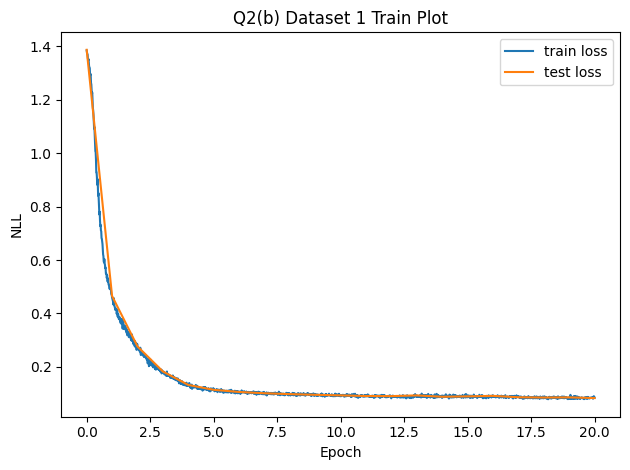

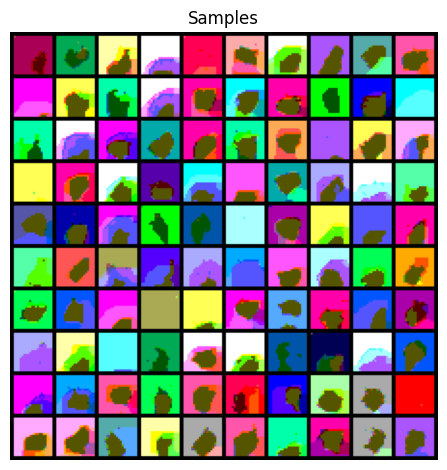

In [20]:
q2b_save_results(1, 'b', q2_b)

In [ ]:
q2b_save_results(2, 'b', q2_b)

Using device: cuda


/tmp/ipykernel_396099/48044251.py:13: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  out = F.conv2d(input, self.weight * self.mask, self.bias, self.stride,


Initial test loss: 1.400796
Epoch: 1/20, Batch: 0/469, Loss: 1.400625
Epoch: 1/20, Batch: 10/469, Loss: 1.194169
Epoch: 1/20, Batch: 20/469, Loss: 0.893311
Epoch: 1/20, Batch: 30/469, Loss: 0.811402
Epoch: 1/20, Batch: 40/469, Loss: 0.736017
Epoch: 1/20, Batch: 50/469, Loss: 0.676768
Epoch: 1/20, Batch: 60/469, Loss: 0.573854
Epoch: 1/20, Batch: 70/469, Loss: 0.500912
Epoch: 1/20, Batch: 80/469, Loss: 0.458540
Epoch: 1/20, Batch: 90/469, Loss: 0.417884
Epoch: 1/20, Batch: 100/469, Loss: 0.373454
Epoch: 1/20, Batch: 110/469, Loss: 0.370114
Epoch: 1/20, Batch: 120/469, Loss: 0.329070
Epoch: 1/20, Batch: 130/469, Loss: 0.344685
Epoch: 1/20, Batch: 140/469, Loss: 0.290054
Epoch: 1/20, Batch: 150/469, Loss: 0.278143
Epoch: 1/20, Batch: 160/469, Loss: 0.273137
Epoch: 1/20, Batch: 170/469, Loss: 0.276505
Epoch: 1/20, Batch: 180/469, Loss: 0.267994
Epoch: 1/20, Batch: 190/469, Loss: 0.267574
Epoch: 1/20, Batch: 200/469, Loss: 0.262410
Epoch: 1/20, Batch: 210/469, Loss: 0.265678
Epoch: 1/20, Ba

# Question 3: Causal Transformer - iGPT

Now we will move onto the current most popular and widespread autoregressive model, the transformer.

## Part (a) Autoregressive Transformer on Shapes and MNIST
In this part, implement a simple Autoregressive Transformer to model binary MNIST and shapes images (same as Q2(a), but with a Transformer). 

Some additional notes about your transformer implementation:
 * iGPT uses learned positional encodings. We recommend to use those here as well. However, you may also use sinusoidal positional encodings if you wish (see the [Attention is All You Need](https://arxiv.org/abs/1706.03762) paper)
 * Autoregressive transformer always predicts the **next** token, give prior tokens. iGPT has a special **\<bos\>** or beginning of sequence token at the start of every sequence every image. Make sure to include this in your implementation as well. You can generate unconditional sample by conditioning with the **\<bos\>** token.
 * While dropout is a common feature in transformer models, you do not need to add it (but may if you wish!).
 * Prebuilt transformers exist in some frameworks (i.e. pytorch). Don't just use an off the shelf implementation as the point of the exercise is to better understand the transformer architecture. Building the transformer from the ground up (use primitives such as Linear/Dense layers, LayerNorm, GeLU, Embedding)
 * Learning rate warmup and cos learning rate decay are often used when training transformers to improve training stability and improve performance. See if this helps your model! Try 1000 steps of warmup with a cosine learning rate decay.

Paper references
* [Attention Is All You Need](https://arxiv.org/abs/1706.03762) 
* [Generative Pretraining from Pixels](https://cdn.openai.com/papers/Generative_Pretraining_from_Pixels_V2.pdf) 
* [Language Models are Unsupervised Multitask Learners](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf)

We recommend the following network design parameters:
* $d_{model}$: 128
* heads: 4
* layers: 2
* GeLU nonlinearities

And the following hyperparameters:
* Batch size: 64 or 32 or 16 (whichever fits in your GPU)
* Learning rate: $10^{-3}$
* 15 epochs or more
* Adam Optimizer (this applies to all Transformers models trained in future parts)

**You will provide these deliverables**

1. Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2. Report the final test set performance of your final model
3. 100 samples from the final trained model



In [ ]:
def q3_a(train_data, test_data, image_shape, dset_id):
  """
  train_data: A (n_train, H, W, 1) uint8 numpy array of color images with values in {0, 1}
  test_data: A (n_test, H, W, 1) uint8 numpy array of color images with values in {0, 1}
  image_shape: (H, W, 1), height, width, and # of channels of the image
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, 1) of samples with values in {0, 1}
  """
  return train_losses, test_losses, samples

### Results

Once you've implemented `q3_a`, execute the cells below to visualize and save your results

In [ ]:
q3ab_save_results(1, 'a', q3_a)

NameError: name 'train_losses' is not defined

In [ ]:
q3ab_save_results(2, 'a', q3_a)

## Part (b) iGPT on Colored Shapes and MNIST

Now, implement an iGPT that models color. In order to reduce the length of token sequences, iGPT models each RGB pixel as a **single** token. This effectively reduces the context length from H*W*C to just H*W. iGPT does this through a k-means clustering approach. Because our images only each can only take on 4 values (2 bits) per channel, we can represent each pixel with 64 values (6 bits). Convert the dataset into an image of tokens and train iGPT on the colored shapes and MNIST dataset.

Checkout the iGPT paper for more details: [Generative Pretraining from Pixels](https://cdn.openai.com/papers/Generative_Pretraining_from_Pixels_V2.pdf) 

Training times and hyperparameter settings should be the same as part (a), except train for longer (15 epochs)

**You will provide these deliverables**

1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model


In [ ]:
def q3_b(train_data, test_data, image_shape, dset_id):
    """
    train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
    test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
    image_shape: (H, W, C), height, width, and # of channels of the image
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
            used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (100, H, W, C) of samples with values in {0, 1, 2, 3}
    """


### Results

Once you've implemented `q3_b`, execute the cells below to visualize and save your results

In [ ]:
q3ab_save_results(1, 'b', q3_b)

In [ ]:
q3ab_save_results(2, 'b', q3_b)

## Part (c) K, V Caching for Improved Inference
You may have noticed that generation from the transformer is quite slow. Part of this is just due to the autoregressive nature. However, another part is due to some computational inefficiency. At each forward pass of the model, we are performing repeat computation of the past sequence. Specifically, we can cache the key and values at the multi attention layer to more quickly predict at each step.

In self-attention, a sequence is processed by generating three vectors for each element in the sequence: a Query (Q), a Key (K), and a Value (V). These vectors are then used to compute attention scores and subsequently the output of the attention layer.
Mathematically, this can be represented as:
 * For each index $i$, compute $Q_i$, $K_i$, $V_i$ for the current element
 * Retrieve $K_{<i}$ and $V_{<i}$ from the cache (where $<i$ denotes all indices before the current one)
 * Compute the attention output using $Q_i$, $[K_{<i}, K_i]$, $[V_{<i}, V_i]$


Next implement caching for your transformer to make inference more efficient by modifying your self attention. Use caching for inference in the future problems for faster generation! (Note caching is only used during inference). You will use the same dataset as in part B, dataset 2 of this question (colored mnist). No training is required in this section, feel free to reuse the model you trained in part B, dataset 2.

**You will provide these deliverables**

1. Over the course of inference, measure the time for the forward pass over the total sequence length with and without caching.
3. 100 samples from the final trained model using the caching inference pipeline.



In [ ]:
def q3_c(train_data, test_data, image_shape, dset_id):
  """
  train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  image_shape: (H, W, C), height, width, and # of channels of the image
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# sampling steps,) numpy array of time per sampling iteration, without caching
  - a (# sampling steps,) numpy array of time per sampling iteration, with without caching
  - a numpy array of size (100, H, C, W) of samples with values in {0, 1, 2, 3} (sample generated without caching)
  - a numpy array of size (100, H, C, W) of samples with values in {0, 1, 2, 3} (sample generated with caching)
  """
  return time_list_no_cache, time_list_with_cache, samples_no_cache, samples_with_cache

### Results

Once you've implemented `q3_c`, execute the cells below to visualize and save your results



In [ ]:
q3c_save_results(2, q3_c)

# Question 4: Causal Transformer: Tokenized Images

## Image Tokenization with Vector Quanization

## Part (a) Image Quantization

Above, we implemented iGPT, which autoregressivly predicts raw pixels. Transformers have quadratic complexity in the sequence length which prevents this naive approach from scaling well to large images.

The space of natural images often contains very correlated information. This suggests we can learn a reduced representation. VQVAE is a method that does just that, learning to map images to a more compact discrete set of tokens. We will cover this method in more detail in future lectures. The only thing you need to know now is that we can learn an encoder (and corresponding decoder), which can extract a discrete representation from an image. 

If you are curious, checkout the VQVAE paper to learn more: https://arxiv.org/abs/1711.00937 (we will cover this in a future lecture though!)

In this part, we provide a pre-trained VQVAE model, which consists of:
 * encoder to tokenize the images
 * the decoder to recover the image
 * a token vocabulary of VQVAE_MODEL.n_embeddings

Below is the code for loading the VQ model. Note that VQVAE encoding process is lossy, so the decoded images will not be the exact same as the input. Some blurriness in the recovered image is to be expected. The docstrings of the relevant methods you will need for the VQVAE_MODEL are provided below for your convenience. 

We will use 2 colored mnist datasets in this part. The first is the same dataset used in previous parts. The second, hads a colored digit on a differently colored background. We will call these datasets Colored MNIST and Colored MNIST v2. Note that the vqvae is trained per dataset.

**You will provide these deliverables**

1. Use the provided encoder model to quantize the images then inspect the recovered images by applying the decoder for each of the two datasets

In [ ]:
# @property
# def n_embeddings(self) -> int:
#     """The size of the token vocabulary"""
#    
# def quantize(self, x: np.ndarray) -> np.ndarray:
#     """Quantize an image x.
#
#     Args:
#         x (np.ndarray, dtype=int): Image to quantize. shape=(batch_size, 28, 28, 3). Values in [0, 3].
#
#     Returns:
#         np.ndarray: Quantized image. shape=(batch_size, 7, 7). Values in [0, n_embeddings]
#     """
#    
# def decode(self, z_index: np.ndarray) -> np.ndarray:
#     """Decode a quantized image.
#
#     Args:
#         z_index (np.ndarray, dtype=int): Quantized image. shape=(batch_size, 7, 7). Values in [0, n_embeddings].
#
#     Returns:
#         np.ndarray: Decoded image. shape=(batch_size, 28, 28, 3). Values in [0, 3].
#     """
# 

In [ ]:
def q4_a(images, vqvae):
  """
  images: (B, H, W, C), the images to pass through the encoder and decoder of the vqvae
  vqvae: a vqvae model, trained on the relevant dataset

  Returns
  - a numpy array of size (2, H, W, C) of the decoded image
  """
  return autoencoded_images

In [ ]:
q4a_save_results(1, q4_a)

In [ ]:
q4a_save_results(2, q4_a)

## Part (b) Autoregressive Transformer on Colored Shapes and MNIST with Vector Quantization

We can use the VQVAE to tokenize an image dataset. This will result in a much smaller sequence length than the approach we tried in Question 3(b). For this part, train a transformer on the dataset tokenized by the VQVAE.

This is a simplified version of the approach used in VQGAN [VQGAN](https://arxiv.org/abs/2012.09841) -> Section 3.2: Learning the Composition of Images with Transformers (Again, we will cover this in more detail in a future lecture!)

Update the following hyperparameters:
* layers: 4 (we can train a bigger transformer now since less memory is used per input!)
* 30 epochs

**You will provide these deliverables**

1. Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2. Report the final test set performance of your final model
3. 100 samples from the final trained model

In [ ]:
def q4_b(train_data, test_data, image_shape, dset_id, vqvae):
  """
  train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  image_shape: (H, W, C), height, width, and # of channels of the image
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets
  vqvae: a vqvae model, trained on dataset dset_id

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, C, W) of samples with values in {0, 1, 2, 3}
  """
  return train_losses, test_losses, samples

### Results

Once you've implemented `q4_b`, execute the cells below to visualize and save your results



In [ ]:
q4b_save_results(1, q4_b)

In [ ]:
q4b_save_results(2, q4_b)

# Question 5: Causal Transformer: Text

Now lets consider text! You are probably already fimilar with autoregressive transformers for text, now more commonly known as Large Language Modesl (LLMs).
We will now implement a simplified version.

We will be detailing with a [small poetry dataset](https://huggingface.co/datasets/merve/poetry). See some of the data below.

In [ ]:
data = visualize_q5_data()

## Part (a) Modeling Text
Train a transformer on the poetry dataset.

Data Preprocessing:
* We will use a simple method to tokenize the data. We will convert each unique character into a token. (Current LLMs use more sophisticated tokenizers, most commonly, [byte-pair encoding](https://huggingface.co/learn/nlp-course/chapter6/5?fw=pt))
* Previously we have leveraged a **\<bos\>** as part of the model, just like iGPT. For text, we may not always sample a sequence that starts at the beginning. Instead, we will add the **\<bos\>** token to the beginning of every sequence in the dataset, and remove the **\<bos\>** token from the model.
* Another problem is that the model must know when to stop sampling. This is done by appending an **\<eos\>**, or end of sequence token at the end of every sequence in the dataset.
* We can now convert the sequence into subsequences of size context_length, for training!

We recommend the following hyperparameters:
* Sequence length: 128
* 5 epochs

**You will provide these deliverables**

1. Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2. Report the final test set performance of your final model
3. Provide **5 unconditional samples** of **128 characters** showcasing the model text generation capabilities (text samples should stop after **\<eos\>**. Text after **\<eos\>** can be removed in post processing)

In [ ]:
import torch.utils.data as data
def q5_a(train_text, test_text):
  """
  train_text: list[str] Train text sequences.
  test_text: list[str] Test text sequences.

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a list of 5 (str), 5 generated samples from the model.
  """
  return train_losses, test_losses, text_samples

### Results

Once you've implemented `q5_a`, execute the cells below to visualize and save your results



In [ ]:
q5a_save_results(q5_a)

# Question 6: Causal Transformer: Multimodal

So far, we have been dealing only with autoregressive generation of a single modality. Now we will train a model that operates on multiple modalities!

We will use the text labeled colored MNIST dataset, which has a text description of the MNIST image. Run the cell below to visualize the data along with the text annotation. This is the Colored MNIST v2 dataset, which also comes with these text labels.

In [ ]:
visualize_q6_data()

## Part (a) Multimodal Text and Image Generation
Implement and train an autoregressive (AR) model capable of handling both text and image data. The model should be designed to process sequences composed of concatenated text and image tokens in both orders (text followed by images and images followed by text). Additionally, the model should be capable of generating unconditional text and image samples.

Data Preprocessing:
* Text Tokens: Map each unique word in the text data to a unique token. (Note that all text descriptions contain the exact same amount of words. This simplifies text processing, as you won't have to deal with sequences of different lengths as in Question 5)
* Image Tokens: Quantize the image data into tokens using the VQVAE tokenizer from Problem 4.
* In this problem, we have 2 modalities. Introduce an **\<end of text\>** token and an **\<end of image\>** token. After seeing such a token, the model should switch to sampling the next modality.
* Formulate batches as sequences of concat([**\<end of image\>**, text_tokens, **\<end of text\>**, image_tokens]) and concat([**\<end of text\>**, image_tokens, **\<end of image\>**, text_tokens]). With a 50/50 split between each ordering.

Inference:
* During inference, we cannot mix modality tokens. During sampling we can restrict the logits to only be within the relevant modality.
* After **\<end of image\>**, only allow the model to sample text tokens (including **\<end of text\>**)
* After **\<end of text\>**, only allow the model to sample image tokens (including **\<end of image\>**)
* At the very start (conditioned on the **\<bos\>** token, only allow the model to sample one of (**\<end of image\>** or **\<end of text\>**))
* As the model may not always correctly sample the **\<end of image\>** token before the image ends, you may add a rule to force the model to always sample the correct number of image tokens (49 tokens).

You can use the same hyperparameters as in 4(b) (but of course, feel free to tune your model to achieve better performance)

**You will provide these deliverables**

1. Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2. Report the final test set performance of your final model
3. 9 conditional samples based on provided text.
4. 9 conditional samples based on provided images.
5. 9 unconditional samples showcasing the model's capability in generating standalone text and images.

In [ ]:
def q6_a(train_data, test_data, image_shape, train_text, test_text, image_test_prompt, text_test_prompt, vqvae):
  """
  train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  image_shape: tuple (H, W, C) The shape of the images in the dataset, indicating height, width, and number of color channels.
  train_text: list[str] Text data associated with each training image.
  test_text: list[str] Text data associated with each test image.
  image_test_prompt: (9, H, W, C) Image data used for generating conditional text samples during testing.
  text_test_prompt: list of 9 strings Text prompts used for generating conditional image samples during testing.
  vqvae: a vqvae model, trained on the relevant dataset

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a list of 9 (image, text), corresponding to the image conditioned samples
  - a list of 9 (image, text), corresponding to the text conditions samples
  - a list of 9 (image, text), corresponding to unconditional samples
  """
  return train_losses, test_losses, samples_image_conditioned, samples_text_conditioned, samples_unconditioned

### Results

Once you've implemented `q6_a`, execute the cells below to visualize and save your results



In [ ]:
q6a_save_results(q6_a)